In [1]:
# Imports

import bmi
import bmi.wrapper
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive, Layout, interact
import numpy as np
import logging
import threading
import time

# Something very fishy happening if I don't define a plot first.
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()
_ = plt.figure()
plt.ion()

In [2]:
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM-old\share\bin\dflowfm'
wrapper = bmi.wrapper.BMIWrapper(engine=engine);
engine = r'C:\Users\vries_cy\OneDrive - Stichting Deltares\Desktop\DFM\x64\dflowfm\bin\dflowfm'
mdufile = r'C:\Users\vries_cy\PAOTM cursus\c081_flow_over_subgrid_groyne\groyne01_Q-H.mdu'

In [3]:
data = []
items = []
wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
wrapper.initialize()

In [4]:

parameters = [
    {
        "parameter": "zbndz",
        "description": "Boundary Water level Downstream [m]",
        "default": str(wrapper.get_var("zbndz")[0]),
        "slice": np.arange(36)
    },    {
        "parameter": "zbndz",
        "description": "Boundary Water level Upstream [m]",
        "default": str(wrapper.get_var("zbndz")[0]),
        "slice": np.arange(36, 72)
    }
]

maxN = 500

In [5]:
# for i in range(wrapper.get_var_count()):
#     print(wrapper.get_var_name(i), wrapper.get_var_shape(wrapper.get_var_name(i)), wrapper.get_var(wrapper.get_var_name(i)))

In [6]:
# Create widgets
style = {'description_width': 'initial'}

run = widgets.Button(
    description='Run model',
    button_style='',
    icon='play'
)
update = widgets.Button(
    description='Single update',
    button_style='',
    tooltip='Update with 1 timestep',
    icon='step-forward'
)
restart = widgets.Button(
    description='Restart model',
    button_style='',
    tooltip='Restart entire model with initial inputs',
    icon='retweet'
)

settings = widgets.HTML(
    value="Welcome!",
    placeholder='Input settings'
)

play = widgets.Play(
#     interval=10,
    value=0,
    min=0,
    max=int(wrapper.get_end_time()),
    step=1,
    description="Press play",
    disabled=False
)


nsteps = widgets.BoundedIntText(
    description="Number of timesteps",
    value=200,
    min=0,
    max=maxN,
    style=style,
    layout=Layout(width='15vw')
)

slider = widgets.IntSlider(  
    min=0,
    max=1,
    value=0
)

widgets.jslink((play, 'value'), (slider, 'value'))
player = widgets.HBox([play, slider])

# parameters = ["zbndz", "zbndq", "frcu"]
# p_descrip = ["Boundary Water level", "Boundary Discharge", "Roughness Chézy"]

items=[]
for p in parameters: 
    items.append(widgets.Text(
        description=p["description"],
        disabled=False,
        value=str(p["default"]),
        placeholder=p["parameter"],
        style=style,
        layout=Layout(width='50vw')
    ))

In [7]:
# Model specific function 

xz = wrapper.get_var('xz')[:]
yz = wrapper.get_var('yz')[:]
indy = np.argsort(yz)[::-1]
newx = xz[indy]

lX = len(np.unique(xz))
lY = len(np.unique(yz))
newx = newx.reshape((lY, lX))
indx = np.argsort(newx, axis=1)

#     Automate parameter and grid sizes
def update_data():
    ucx = wrapper.get_var('ucx')[:]
    ucy = wrapper.get_var('ucy')[:]
    mag = np.sqrt(ucx.copy()**2 + ucy.copy()**2)

    mag = mag[indy]
    mag = mag.reshape((lY, lX))
#     ucx = ucx[indy]
#     ucx = ucx.reshape((lY, lX))
#     ucy = ucy[indy]
#     ucy = ucy.reshape((lY, lX))
    
    c = np.zeros_like((mag))
#     ux = np.zeros_like((ucx))
#     uy = np.zeros_like((ucy))

    for i, x in enumerate(mag):
        c[i, :] = mag[i, indx[i]]
#         ux[i, :] = ucx[i, indx[i]]
#         uy[i, :] = ucy[i, indx[i]]

    data.append(dict({
        "time": wrapper.get_current_time(),
        "ucx": ucx, 
        "ucy": ucy, 
        "mag": c,
    }))
    slider.max = len(data)
    settings.value = "Model update, timestep: {}".format(data[-1]["time"])
update_data()


In [8]:
# Standard functions for button widgets
dostop = False
def update_model(b=None):
#     Update the model with t = 1
    wrapper.update(wrapper.get_time_step())
    if(data[-1]["time"] != wrapper.get_current_time()):
        update_data()

def start_loop(n):
    print(n)
#     Start the loop for running the model continuously
#     while run.value == True: 
    for i in range(n):
        update_model()
        if (wrapper.get_current_time() >= wrapper.get_end_time()):
            stop_model()
            break
        if dostop == True: 
            stop_model()
            break
    stop_model()

def run_model(change=None): 
#     When the run/stop model button is pressed either start the model loop or stop it
    run.disabled = True
    update.disabled = True
    restart.disabled = True
    for i in items:
        i.disabled = True
    start_loop(int(nsteps.value))
#         thread = threading.Thread(target=start_loop)
#         thread.start()

def stop_model(change=None):
    update.disabled = False
    restart.disabled = False
    run.disabled = False
    for i in items:
        i.disabled = False
    dostop = True

def change_param(v):
    try:
        v = v.owner
    except AttributeError: 
        v = v
    if v.value == "":
        return
    try:
        float(v.value)
        old_par = wrapper.get_var(v.placeholder)
        new_par = np.ones_like(old_par) * float(v.value)
        wrapper.set_var(v.placeholder, new_par)
        settings.value = "Value ({}) has been set to: {}".format(v.description, new_par[0])
    except ValueError:
        v.value = str(next((x['default'] for x in parameters if x['parameter'] == v.placeholder), None))
        settings.value = "Not a correct input for {}".format(v.description)

def start_model():
#     start model
    wrapper = bmi.wrapper.BMIWrapper(engine=engine, configfile=mdufile)
    wrapper.initialize()
    update_data()
    for i in range(len(items)): 
        items[i].value = str(wrapper.get_var(parameters[i])[0])
        
def restart_model(b=None):
#     stop the model and call function to restart the model
    del data[:]
    wrapper.finalize()
    start_model()
    settings.value = "Restarting model"

<IPython.core.display.Javascript object>


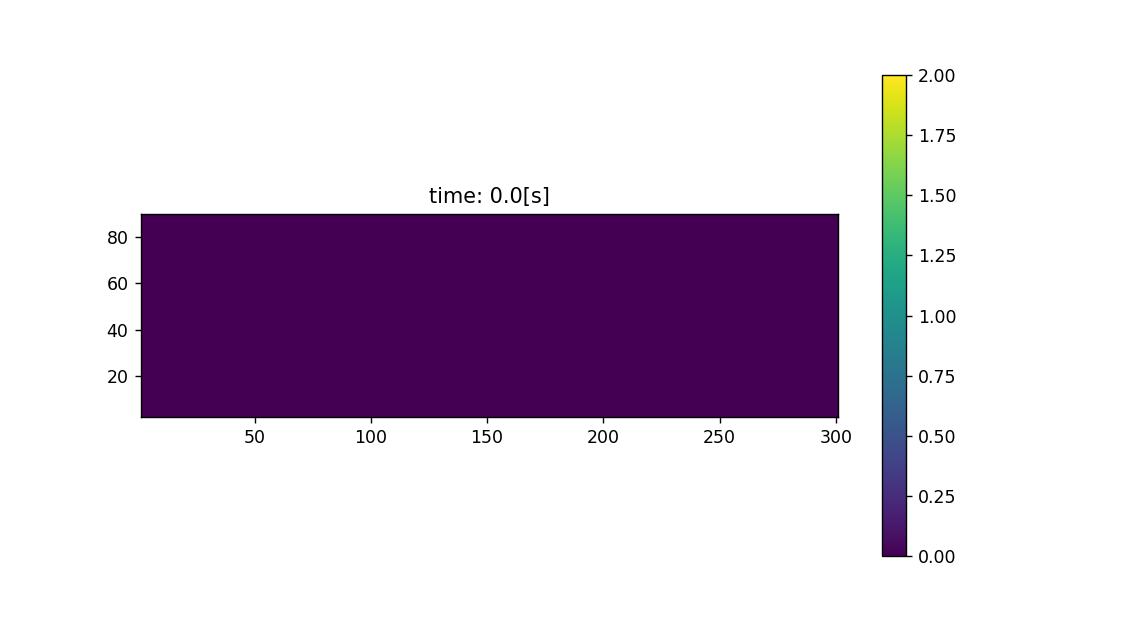

200


In [13]:
# set plot size
plt.rcParams["figure.figsize"] = (9, 5) # (w, h)

# link functions to widgets
run.on_click(run_model)
update.on_click(update_model)
restart.on_click(restart_model)

def set_plot(change):
    t = change['new']
    if (t < len(data)):
        im.set_data(data[t]["mag"])
#         vortscat.set_array(data[t]["magR"])
        plt.title("time: " + str(data[t]["time"]) + "[s]")
#         quiver.set_UVC(data[t]["ucx"][::5], data[t]["ucy"][::5])
        fig.canvas.draw()
        
player.children[-1].observe(set_plot, 'value')

controls = HBox([run, update, restart])
params = VBox(items)

for i in items: 
    change_param(i)
    i.observe(change_param, names='value')

display(VBox([settings, HBox([nsteps, controls]), HBox([params])]))
fig, axs = plt.subplots(1, 1)
display(player)

im = axs.imshow(data[0]["mag"], extent=[xz.min(), xz.max(), yz.min(), yz.max()], vmin=0, vmax=2)
# vortscat = axs.scatter(xz, yz, marker="s", c=data[0]["magR"], vmin=0, vmax=2)
# quiver = axs.quiver(X[::5], Y[::5], data[0]["ucx"][::5], data[0]["ucy"][::5])
plt.title("time: " + str(data[0]["time"]) + "[s]")

plt.colorbar(im);


In [10]:
# plt.figure()
# t = plt.scatter(xz, yz, c=np.arange(len(xz)))
# plt.colorbar(t)

In [11]:

# coords = np.vstack((xz[:-72], yz[:-72]))
# # coords = coords.transpose()
# plt.figure()
# t = plt.scatter(xz[:-72], yz[:-72], c=data[400]["magR"][:-72])
# plt.colorbar(t)

In [12]:
t = 300
lX = len(np.unique(xz))
lY = len(np.unique(yz))

xz = wrapper.get_var('xz')[:]
yz = wrapper.get_var('yz')[:]

indy = np.argsort(yz)[::-1]
ucx = data[t]["ucx"]
ucy = data[t]["ucy"]
mag = np.sqrt(ucx.copy()**2 + ucy.copy()**2)

newx = xz[indy]
newx = newx.reshape((lY, lX))
indx = np.argsort(newx, axis=1)

mag = mag[indy]
mag = mag.reshape((lY, lX))

c = np.zeros_like((mag))
for i, x in enumerate(mag):
    c[i, :] = mag[i, indx[i]]
    
plt.figure()

plt.imshow(c, extent=[xz.min(), xz.max(), yz.min(), yz.max()], vmin=0, vmax=2.5)
plt.colorbar()

IndexError: list index out of range

In [ ]:
plt.figure()
print(xz, yz,  data[100]["ucx"])
quiver = plt.quiver(xz, yz, data[0]["ucx"], data[0]["ucy"])


In [ ]:

# xz = wrapper.get_var('xz')[:-72]
# yz = wrapper.get_var('yz')[:-72]
# c = xz.copy()
# # c = data[400]["magR"][:-72]

# lX = len(np.unique(xz))
# lY = len(np.unique(yz))

# indx = np.argsort(xz + 30000 * yz)
# newc = c[indx]
# c = c.reshape((lX, lY))


# # x = xz.reshape((lX, lY))
# # indx = np.argsort(x, axis=0)
# # print(indx)
# # indy = np.argsort(yz)

# # y = yz.reshape((lX, lY))
# # indy = np.argsort(y, axis=1)

# # coords = np.vstack((xz, yz))
# # coords = coords.transpose()
# # print(coords)
# # test = sorted(coords, key=lambda k: [k[1], k[0]])
# # print(test)
# # print(indx, indy)
# # c = data[400]["magR"]
# # c = c.reshape((lX, lY))
# # c = c[indx, indy]
# # c = c.transpose()

# # print(c)

In [ ]:
# plt.figure()
# plt.imshow(c, extent=[xz.min(), xz.max(), yz.min(), yz.max()])

In [ ]:

# xz = wrapper.get_var('xz')[:]
# yz = wrapper.get_var('yz')[:]

# lX = len(np.unique(xz))
# lY = len(np.unique(yz))

# newX = xz 

In [ ]:
# plt.figure()
# plt.imshow(c,  extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=2.5)
# plt.colorbar()

In [ ]:
# ind = np.argsort(xz)

# lX = len(np.unique(xz))
# lY = len(np.unique(yz))
# x = xz.reshape((lX, lY))
# y = yz.reshape((lX, lY))


# indx =  order=('x','y')
# print(indx)
# # print(indx)
# c = data[400]["magR"]
# c = c.reshape((lX, lY))
# c = c[test]

# print(np.shape(c))



In [ ]:
# a = np.array([0, 1, 2, 3, 4, 5, 6, 7])
# a = a.reshape((2, 4)).transpose()
# print(a)
# plt.figure()
# plt.imshow(a)

In [ ]:
# import random
# a = np.arange(9)
# b = np.arange(0, 90, 10)
# random.shuffle(a)
# d = b[a]
# c = np.reshape(a, (3, 3))
# print(c, d)

In [ ]:
# print(A, B)